# Simple Recurrent Neural Network

再帰型ニューラルネットは、音声や自然言語処理、動画といった系列データを扱うニューラルネットになります。  
これらのデータセットは、一般に、その長さがまちまちで、そして系列内の要素の並び(文脈)に意味があることが特徴です。  
  
RNNは、それら特徴量をうまく抽出してくれる便利なニューラルネットになります。  
今回は、一番簡単な再帰型ニューラルネットを紹介します。次回、応用編のLSTM(Long-Short Term Memory: 長・短期記憶)をみていきます。   

### 系列データの分類について
音声、ビデオ、テキスト、またそれらに付随する様な系列データは、横方向に時間軸($ 1, 2, ... , T-1, T$)があります。  
つまり、並びに意味をもつデータになります。  
系列データを扱う推定問題の例としては、文章が途中まで学習データとして与えられていて、  
次の単語がどのような単語が来るかを予測(類推)する問題などがあります。  

### RNNの構造について
再帰型ニューラルネット(RNN)は、ニューラルネット内部に、閉路をもつ構造を持ちます。つまり、情報をグルグル更新できる構造があるわけです。  
このおかげで、並びに意味をもつ系列データの情報を、鎖の様につなぎとめつつ、新しい情報に基づき情報を更新したり、次の鎖に情報を伝搬すること  
が可能となります。  
  
情報を一時的に記憶する、という構造をニューラルネット内部に持っている、これを再帰型ニューラルネットの特徴となります。  
これのおかげで、系列データの中にある『文脈』を捉えて、分類問題をうまく処理することが可能となります。  
順伝搬型ニューラルネットとの違いは、ここにあります。  
  
順伝搬型ニューラルネットは、情報を単純に横流ししていきますが、  
再帰型ニューラルネットは、情報を更新する層があるという理解でも構いません。  
  
この記憶、についてですが、一般的には、中間層に十分な数のユニットがあれば、任意の系列から系列への写像(情報の受け渡し)を、ある程度の精度で  
近似させることが可能です。  
  
系列データが、全体が一括して与えられるとき(文章など)は、その系列データを逆向き($ T, T-1, T-2, ... , 1$)に、RNNに入力する場合もあります。  
順方向と逆方向、それぞれにRNNに入力して両者の出力層を統合したものを、**双方向性RNN(Bi-directional RNN)**といいます。  
  
これは文章などや、固定された系列データには利用できて、順方向のRNNと比較すると、精度良く作れますが、  
系列データが、時々刻々と与えられる様な機械翻訳などの問題を、オンラインで推定する場合には利用できません。

### 順伝搬および逆伝搬の計算について
補助資料で外観のイメージ理解をしたいと思います。

### ここではおなじみのMNIST画像データを用いて、画像を"系列データ"とみなして、教師あり学習してみる

**いつものおまじないインポート**  
**numpy: Python向けの数値演算ライブラリ**  
**matplotlib: データ可視化のためのライブラリ**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**今回も手軽に, MNISTの数字画像データを用います**

In [4]:
# kerasから"MNIST"(0~9の数字が描かれた画像データ)をロードする
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

`shape` **で** `x_train` **と** `x_test` **の配列を確認**  
28×28の画像サイズがそれぞれ、60,000枚と10,000枚あることがわかる

In [5]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

**正規化する**

In [6]:
# 28*28の２次元配列を、784要素の1次元配列に変換する＆256階調を[0, 1]に正規化
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255

`shape` **で正解らべる(教師ラベル)** `y_train` **と** `y_test` **の配列を確認**  
60,000個と10,000個のラベルが用意されていることがわかる

In [7]:
y_train.shape, y_test.shape

((60000,), (10000,))

**正解ラベルを機械学習用の one-hot ベクトルに変換するために、**  `keras.utils.np_utils` **をインポート**

In [8]:
from keras.utils import np_utils

In [9]:
# 0~9の数字を、10次元で表現する
y_train_array = np_utils.to_categorical(y_train, 10)
y_test_array  = np_utils.to_categorical(y_test, 10)

**変換された正解ラベル(教師ラベル)** `y_train` **と** `y_test` **の配列を確認**  
60,000×10と10,000×10のラベルが用意されていることがわかる

In [10]:
y_train_array.shape, y_test_array.shape

((60000, 10), (10000, 10))

In [21]:
# １番目のラベル
y_train_array[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

**正解ラベルのone-hot ベクトルから、配列から、いちいち目視で確認は辛いので**  
**例えば、numpyの** `where` **を用いて『0よりも大きい要素の位置を取得』でも確認できる**

In [23]:
np.where(y_train_array[0] > 0)[0][0]

5

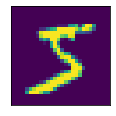

In [22]:
# 学習用データ0番目の画像データ可視化
ax = plt.subplot(2, 2, 1)
plt.imshow(x_train[0])
#plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

**ここから、** `SimpleRNN` **を用いてモデルを構築してみます。比較的簡単に作れます。**

In [11]:
from keras.layers import SimpleRNN, Dense
from keras.models import Model, Sequential

In [12]:
model_SimpleRNN = Sequential()        
model_SimpleRNN.add(SimpleRNN(128, input_shape=(28,28)))
model_SimpleRNN.add(Dense(10, activation='softmax'))

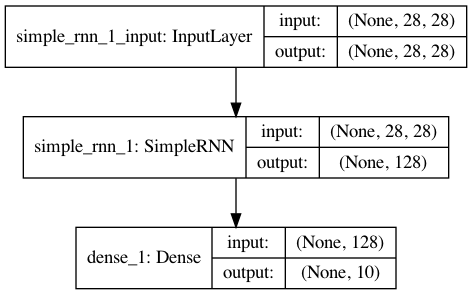

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model_SimpleRNN, to_file="architecture_simplernn.png", show_shapes=True)

In [15]:
model_SimpleRNN.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

In [16]:
his = model_SimpleRNN.fit(x_train, y_train_array,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, y_test_array))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s 211us/step - loss: 0.0723 - accuracy: 0.9751 - val_loss: 0.0397 - val_accuracy: 0.9869
Epoch 2/50
60000/60000 [==============================] - 12s 195us/step - loss: 0.0354 - accuracy: 0.9883 - val_loss: 0.0382 - val_accuracy: 0.9873
Epoch 3/50
60000/60000 [==============================] - 12s 198us/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0245 - val_accuracy: 0.9919
Epoch 4/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.0232 - val_accuracy: 0.9927
Epoch 5/50
60000/60000 [==============================] - 12s 193us/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.0215 - val_accuracy: 0.9932
Epoch 6/50
60000/60000 [==============================] - 12s 193us/step - loss: 0.0187 - accuracy: 0.9939 - val_loss: 0.0211 - val_accuracy: 0.9932
Epoch 7/50
60000/60000 [==============================] 

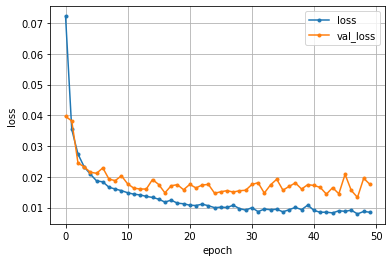

In [17]:
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**後半過学習してるみたいです。。。Early Stopping(学習の早期打ち切り)してもよかったですね。**  
スコア(モデル性能)はどんなものか確認してみます。

In [19]:
# 評価
score = model_SimpleRNN.evaluate(x_test, y_test_array, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.017532821795297786
Test accuracy : 0.9950292706489563


**予測させるときの入力データの形に気をつけてください。**  
単純に、`(28, 28)` の画像データを `.predict()` しても、エラーをはきます。  
配列の形は、この場合、`(1, 28, 28)`になっていることに気をつけてください。

In [26]:
pred = model_SimpleRNN.predict(x_test[1500].reshape(1, x_test.shape[1], x_test.shape[2]))

In [28]:
print(x_test[1500].shape)
print(x_test[1500].reshape(1, x_test.shape[1], x_test.shape[2]).shape)

(28, 28)
(1, 28, 28)


In [29]:
pred

array([[1.4461632e-03, 3.5284430e-02, 2.2971644e-03, 1.1183526e-03,
        1.6589209e-03, 2.5302950e-05, 4.6961643e-05, 9.4953477e-01,
        6.9901384e-03, 1.5976904e-03]], dtype=float32)

`array` **配列に格納されているものは、『どの数字に当てはまるか？』の確率値(浮動小数点)が入ってます。  
仮に言うならば、"信頼度" なるものでしょうか。したがって、当てはまる数字の高いものを選ぶべきで、例えば、"50%=0.5"を基準にすれば**  
先ほどの、numpyの`where`を使って

In [30]:
np.where(pred[0] > 0.5)[0][0]

7

**本当に、数字の7かどうかを調べます**  

In [32]:
y_test[1500]

7

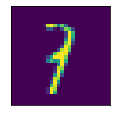

In [31]:
ax = plt.subplot(2, 2, 1)
plt.imshow(x_test[1500])
#plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

**私は。。。数字"3"に見えますが、あの特殊な、７の書き方なんでしょうね。面白いデータを見つけましたw**

**その他、参考となる記事のご紹介...(足りないところは、こちらの記事で補っていただけると幸いです)**  
**[cvusk氏のQiita記事 ディープラーニングで音声分類](https://qiita.com/cvusk/items/61cdbce80785eaf28349)**  
**[AGIRobots 単純再帰型ニューラルネットワークで正弦波を学習させる](https://agirobots.com/blog-ai-ml-research-sin-simplernn/)**